In [41]:
import scipy.io as sio

In [42]:
data = sio.loadmat('BaxterDirectDynamics.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Fri Feb 26 16:51:50 2016',
 '__version__': '1.0',
 '__globals__': [],
 'baxtertraj1': array([[ 0.07823302, -0.05100486, -0.16950488, ...,  0.        ,
          0.01011169, -0.00187254],
        [ 0.07823302, -0.04947088, -0.16950488, ..., -0.00299606,
         -0.00898817,  0.00786465],
        [ 0.07823302, -0.04985438, -0.16950488, ..., -0.00599211,
          0.0108607 ,  0.00936268],
        ...,
        [ 0.07900001, -0.05138836, -0.1675874 , ..., -0.01685282,
          0.00711563,  0.00973718],
        [ 0.07900001, -0.05100486, -0.1675874 , ...,  0.00674113,
         -0.00449408,  0.00262155],
        [ 0.07900001, -0.05100486, -0.1675874 , ...,  0.00674113,
         -0.00449408,  0.00262155]]),
 'baxtertraj10': array([[ 0.07784952, -0.04947088, -0.16988837, ...,  0.00786465,
         -0.00823915, -0.00674113],
        [ 0.07823302, -0.04908739, -0.16912138, ...,  0.00486859,
         -0.00599211, -0.00262155],

In [3]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

In [52]:
# Assuming 'baxtertraj1', 'baxtertraj2', etc. are the trajectory keys
trajectories = [data[key] for key in data.keys() if key.startswith('baxtertraj')]

# Randomly shuffle the trajectories
np.random.shuffle(trajectories)

# Determine the maximum trajectory length
max_length = max(len(traj) for traj in trajectories)

# Pad the trajectories with zeros to match the maximum length
padded_trajectories = [np.pad(traj, ((0, max_length - len(traj)), (0, 0)), 'constant') for traj in trajectories]

# Convert trajectory data to PyTorch tensors
inputs = torch.tensor([traj[:, :21] for traj in padded_trajectories], dtype=torch.float32)
targets = torch.tensor([traj[:, 21:] for traj in padded_trajectories], dtype=torch.float32)

# Print out the lengths of the trajectories for diagnosis
lengths = [len(traj) for traj in padded_trajectories]
print("Trajectory Lengths:", lengths)

# Determine the split ratio (e.g., 80% for training, 20% for validation)
train_ratio = 0.8
num_trajectories = len(padded_trajectories)
num_train = int(train_ratio * num_trajectories)
num_valid = num_trajectories - num_train

# Split into training and validation sets
train_inputs, valid_inputs = inputs[:num_train], inputs[num_train:]
train_targets, valid_targets = targets[:num_train], targets[num_train:]

# Define Custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        return self.inputs[index], self.targets[index]

# Instantiate Custom Dataset objects for training and validation
train_dataset = CustomDataset(train_inputs, train_targets)
valid_dataset = CustomDataset(valid_inputs, valid_targets)

# Create Custom DataLoader for training and validation
batch_size = 64  # Set your desired batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

Trajectory Lengths: [2099, 2099, 2099, 2099, 2099, 2099, 2099, 2099, 2099, 2099]


In [53]:
# Define Custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        return self.inputs[index], self.targets[index]

In [54]:
# Instantiate Custom Dataset objects for training and validation
train_dataset = CustomDataset(train_inputs, train_targets)
valid_dataset = CustomDataset(valid_inputs, valid_targets)

# Create Custom DataLoader for training and validation
batch_size = 16  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

In [65]:
import torch.nn as nn

class DeterministicModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DeterministicModel, self).__init__()
        # Define your architecture here
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256,256)
        self.fc3 = nn.Linear(256, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [56]:
class GaussianModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GaussianModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.mean_fc = nn.Linear(128, output_dim)
        self.std_fc = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        mean = self.mean_fc(x)
        std = torch.exp(self.std_fc(x))  # Ensure standard deviation is positive
        return mean, std


In [57]:
%matplotlib inline
import matplotlib.pyplot as plt

In [66]:

# Initialize the deterministic model
input_dim = 21  # Adjust according to  dataset
output_dim = 14  # Adjust according to  dataset
deterministic_model = DeterministicModel(input_dim, output_dim)


In [67]:
import torch.optim as optim
num_epochs = 100
train_losses = []
valid_losses = []

#Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
deterministic_optimizer = optim.Adam(deterministic_model.parameters(), lr=0.0005)


In [68]:
for epoch in range(num_epochs):
    # Training
    deterministic_model.train()
    total_train_loss = 0.0
    for inputs, targets in train_loader:
        deterministic_optimizer.zero_grad()
        outputs = deterministic_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        deterministic_optimizer.step()
        total_train_loss += loss.item() * len(inputs)
    train_loss = total_train_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    deterministic_model.eval()
    total_valid_loss = 0.0
    with torch.no_grad():
        for inputs, targets in valid_loader:
            outputs = deterministic_model(inputs)
            loss = criterion(outputs, targets)
            total_valid_loss += loss.item() * len(inputs)
    valid_loss = total_valid_loss / len(valid_loader.dataset)
    valid_losses.append(valid_loss)

    # Print the training and validation losses at each epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}")


Epoch [1/100] - Train Loss: 0.7279, Validation Loss: 0.9501
Epoch [2/100] - Train Loss: 0.6167, Validation Loss: 0.8615
Epoch [3/100] - Train Loss: 0.5366, Validation Loss: 0.7966
Epoch [4/100] - Train Loss: 0.4806, Validation Loss: 0.7491
Epoch [5/100] - Train Loss: 0.4406, Validation Loss: 0.7112
Epoch [6/100] - Train Loss: 0.4091, Validation Loss: 0.6791
Epoch [7/100] - Train Loss: 0.3813, Validation Loss: 0.6520
Epoch [8/100] - Train Loss: 0.3559, Validation Loss: 0.6296
Epoch [9/100] - Train Loss: 0.3330, Validation Loss: 0.6113
Epoch [10/100] - Train Loss: 0.3131, Validation Loss: 0.5967
Epoch [11/100] - Train Loss: 0.2963, Validation Loss: 0.5850
Epoch [12/100] - Train Loss: 0.2826, Validation Loss: 0.5744
Epoch [13/100] - Train Loss: 0.2707, Validation Loss: 0.5635
Epoch [14/100] - Train Loss: 0.2600, Validation Loss: 0.5517
Epoch [15/100] - Train Loss: 0.2498, Validation Loss: 0.5389
Epoch [16/100] - Train Loss: 0.2402, Validation Loss: 0.5249
Epoch [17/100] - Train Loss: 0.23

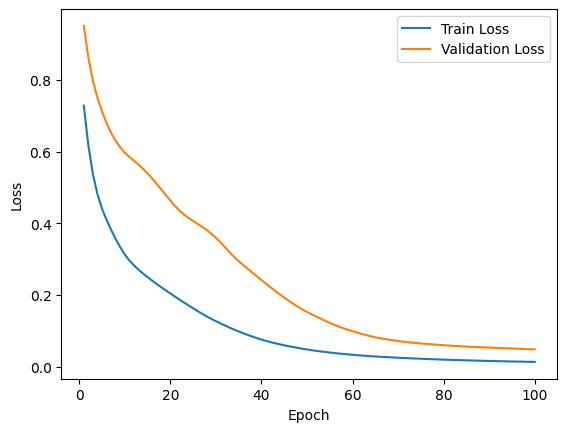

In [69]:
# Plot the learning progress
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [70]:
# Initialize the Gaussian model
gaussian_model = GaussianModel(input_dim, output_dim)

# Define the optimizer for Gaussian model
gaussian_optimizer = optim.Adam(gaussian_model.parameters(), lr=0.001)

# Define the loss function for Gaussian model
def gaussian_loss(prediction, target, std):
    mse_loss = torch.mean((prediction - target)**2)
    std_loss = torch.mean(torch.log(std)**2)  # Regularization term for std
    return mse_loss + std_loss

def train_gaussian(model, optimizer, dataloader):
    model.train()
    total_loss = 0.0
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        mean, std = model(inputs)
        loss = gaussian_loss(mean, targets, std)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(inputs)
    return total_loss / len(dataloader.dataset)

def validate_gaussian(model, dataloader):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, targets in dataloader:
            mean, std = model(inputs)
            loss = gaussian_loss(mean, targets, std)
            total_loss += loss.item() * len(inputs)
    return total_loss / len(dataloader.dataset)


In [71]:
num_epochs = 100
train_loss_gaussian = []
valid_loss_gaussian = []
for epoch in range(num_epochs):
    train_loss = train_gaussian(gaussian_model, gaussian_optimizer, train_loader)
    valid_loss = validate_gaussian(gaussian_model, valid_loader)
    train_loss_gaussian.append(train_loss)
    valid_loss_gaussian.append(valid_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}")


Epoch [1/100] - Train Loss: 0.9502, Validation Loss: 0.9679
Epoch [2/100] - Train Loss: 0.7894, Validation Loss: 0.8898
Epoch [3/100] - Train Loss: 0.6740, Validation Loss: 0.8409
Epoch [4/100] - Train Loss: 0.5919, Validation Loss: 0.8129
Epoch [5/100] - Train Loss: 0.5347, Validation Loss: 0.7978
Epoch [6/100] - Train Loss: 0.4953, Validation Loss: 0.7870
Epoch [7/100] - Train Loss: 0.4662, Validation Loss: 0.7760
Epoch [8/100] - Train Loss: 0.4428, Validation Loss: 0.7625
Epoch [9/100] - Train Loss: 0.4222, Validation Loss: 0.7460
Epoch [10/100] - Train Loss: 0.4030, Validation Loss: 0.7266
Epoch [11/100] - Train Loss: 0.3846, Validation Loss: 0.7055
Epoch [12/100] - Train Loss: 0.3671, Validation Loss: 0.6845
Epoch [13/100] - Train Loss: 0.3508, Validation Loss: 0.6644
Epoch [14/100] - Train Loss: 0.3356, Validation Loss: 0.6454
Epoch [15/100] - Train Loss: 0.3213, Validation Loss: 0.6273
Epoch [16/100] - Train Loss: 0.3081, Validation Loss: 0.6110
Epoch [17/100] - Train Loss: 0.29

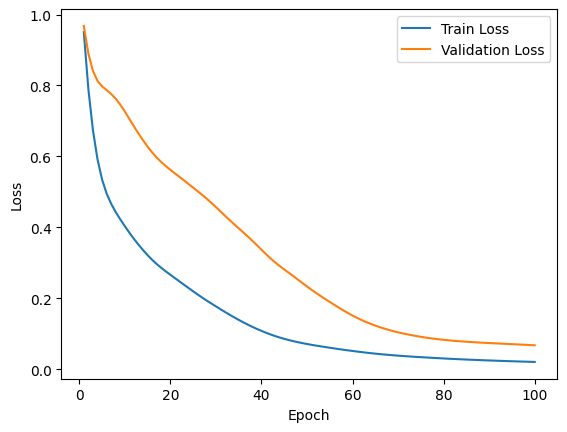

In [72]:
# Plot the learning progress
plt.plot(range(1, num_epochs + 1), train_loss_gaussian, label='Train Loss')
plt.plot(range(1, num_epochs + 1), valid_loss_gaussian, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [73]:
import scipy.stats as stats

def evaluate_gaussian_model(model, dataloader):
    model.eval()
    predicted_means = []
    predicted_stds = []
    ground_truth = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            mean, std = model(inputs)
            predicted_means.append(mean)
            predicted_stds.append(std)
            ground_truth.append(targets)

    predicted_means = torch.cat(predicted_means, dim=0)
    predicted_stds = torch.cat(predicted_stds, dim=0)
    ground_truth = torch.cat(ground_truth, dim=0)

    # Calculate the p-values for each predicted sample
    p_values = stats.norm.cdf(ground_truth.cpu().numpy(), loc=predicted_means.cpu().numpy(), scale=predicted_stds.cpu().numpy())

    # Calculate the mean p-value across all samples and dimensions
    mean_p_value = torch.mean(torch.tensor(p_values))

    return mean_p_value

In [74]:
# Evaluate the Gaussian model on the validation set
mean_p_value = evaluate_gaussian_model(gaussian_model, valid_loader)
print(f"Mean P-Value: {mean_p_value.item()}")


Mean P-Value: 0.513554870395544


In [75]:
def evaluate_deterministic_model(model, dataloader):
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model(inputs)
            all_predictions.extend(outputs.numpy())
            all_targets.extend(targets.numpy())

    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    # Calculate the mean squared error (MSE)
    mse = ((all_predictions - all_targets) ** 2).mean()

    # Calculate the p-value using the t-test
    _, p_value = stats.ttest_rel(all_predictions, all_targets)

    # Convert the p-value array to a scalar value (e.g., by taking the mean)
    p_value_scalar = np.mean(p_value)

    return mse, p_value_scalar

# Evaluate the deterministic model on the validation set
deterministic_mse, deterministic_p_value = evaluate_deterministic_model(deterministic_model, valid_loader)

print("Deterministic Model:")
print(f"Mean Squared Error (MSE): {deterministic_mse:.4f}")
print(f"P-value: {deterministic_p_value:.4f}")

Deterministic Model:
Mean Squared Error (MSE): 0.0484
P-value: 0.4015
